In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

data_path = "E:/Mouse_V1/"

sample_IDs = ["Projection_Seq_Glut", "P28_glut"]

accum_adata, cell_count = [], 0
for sample in sample_IDs:
    pre_path = data_path + sample + ".h5ad"
    temp_adata = sc.read_h5ad(
        pre_path,
                              )
    temp_adata.var_names_make_unique()
    if "P28" in sample:
        temp_adata.X = temp_adata.raw.X
    accum_adata.append(temp_adata)
    cell_count += temp_adata.n_obs

adata = accum_adata[0].concatenate(*accum_adata[1:], batch_categories=sample_IDs)

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [2]:
# import pandas as pd

# adata.obs.reset_index(inplace=True, drop=True)

# VISs = adata.obs["VISs"]
# adata.obs["VISs"] = [None] * adata.shape[0]
# for idx, vis in enumerate(VISs):
#     if vis in ["LM", "RL", "LM-RL"]:
#         adata.obs.loc[idx, "VISs"] = vis
#     else:
#         adata.obs.loc[idx, "VISs"] = "None"

In [6]:
dataset = []
for batch in adata.obs["batch"]:
    if "P28" in batch:
        dataset.append("Cell Paper")
    else:
        dataset.append("Projection-seq")
adata.obs["dataset"] = dataset

In [7]:
mask = np.array(np.isnan(adata.obs["UPB1"]))

for upb in ["UPB1", "UPB2", "UPB4", "UPB6"]:
    adata.obs.loc[mask, upb] = 0.0

In [4]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


2023-06-05 13:16:36,643 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-05 13:16:42,203 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-05 13:16:42,378 - harmonypy - INFO - Iteration 1 of 20
2023-06-05 13:16:49,615 - harmonypy - INFO - Iteration 2 of 20
2023-06-05 13:16:56,746 - harmonypy - INFO - Iteration 3 of 20
2023-06-05 13:17:04,126 - harmonypy - INFO - Iteration 4 of 20
2023-06-05 13:17:11,743 - harmonypy - INFO - Iteration 5 of 20
2023-06-05 13:17:19,586 - harmonypy - INFO - Iteration 6 of 20
2023-06-05 13:17:22,523 - harmonypy - INFO - Iteration 7 of 20
2023-06-05 13:17:25,214 - harmonypy - INFO - Converged after 7 iterations


computing neighbors


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:38)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


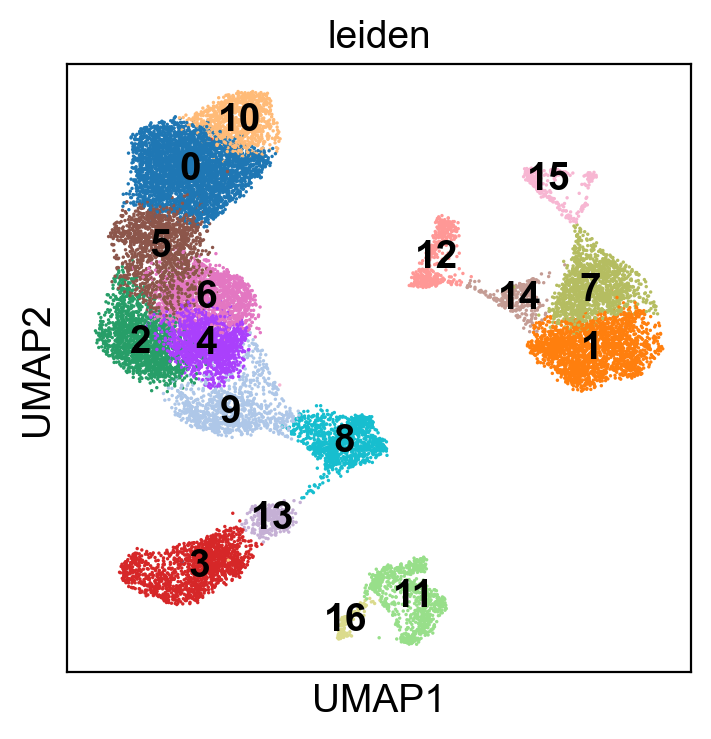

In [8]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "dataset", max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata, key_added="leiden")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


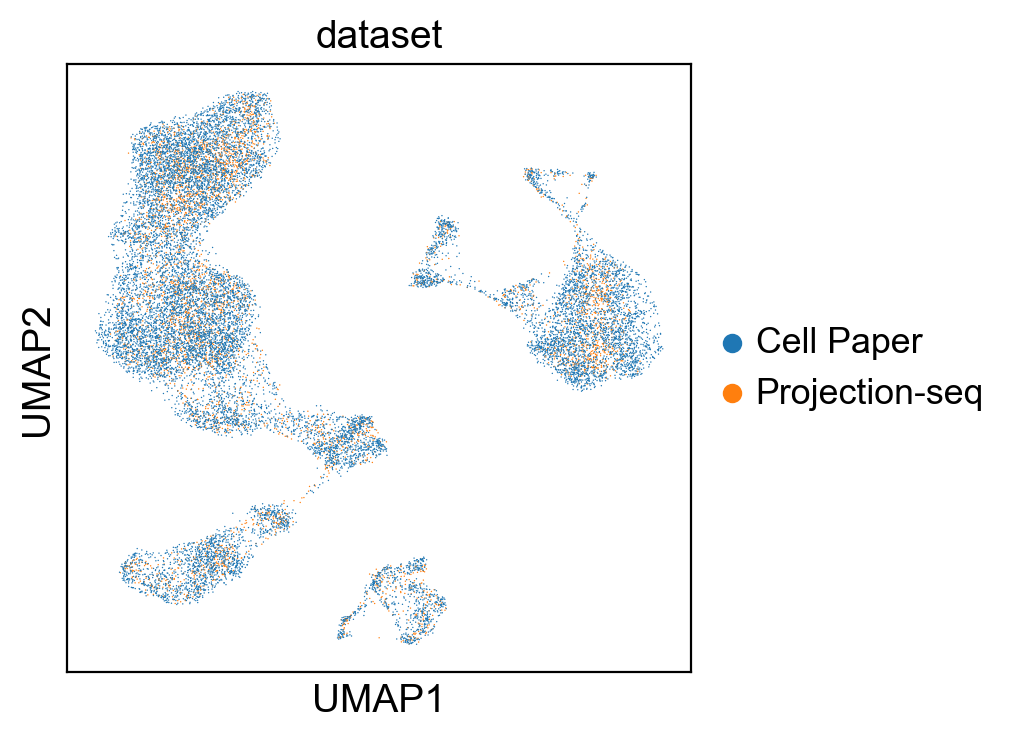

In [9]:
sc.pl.umap(adata, color=["dataset"], alpha=1, size=1)

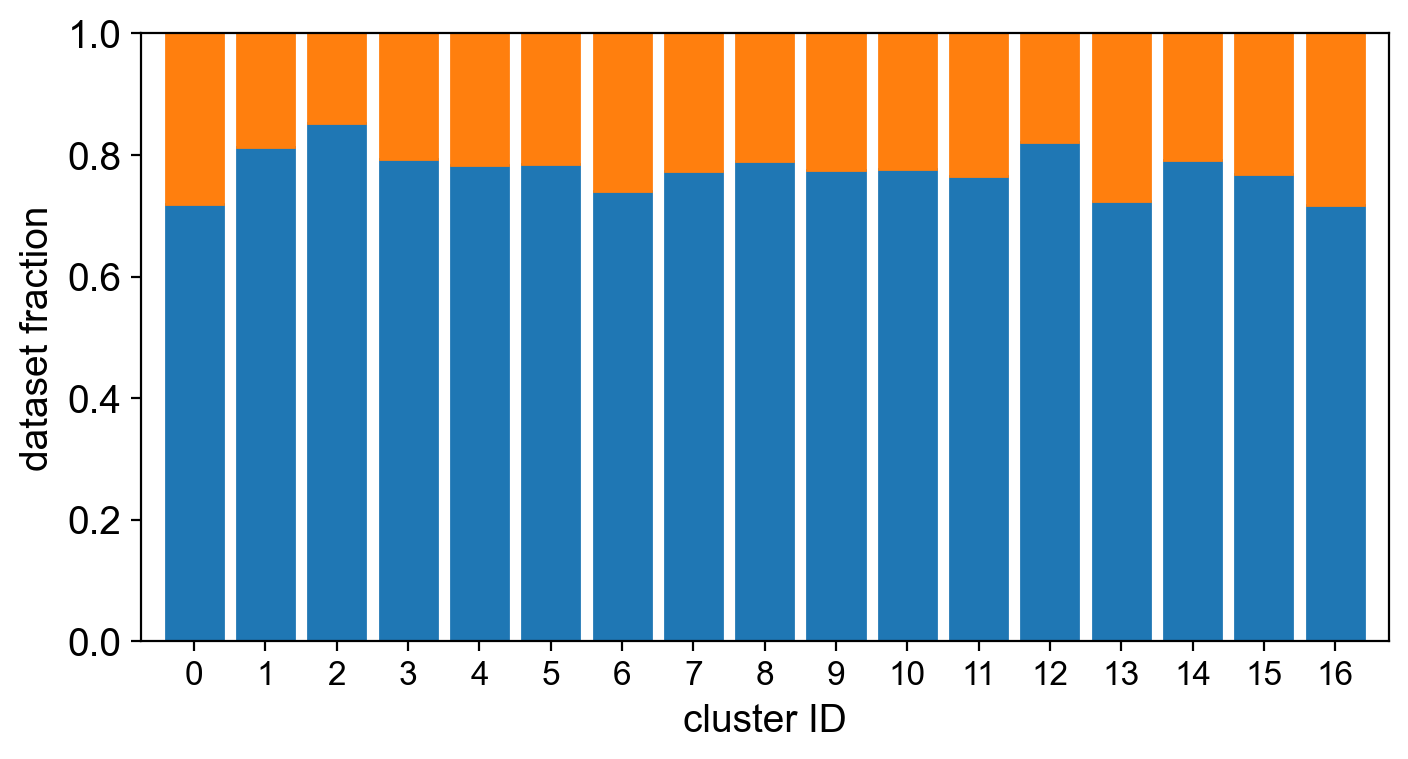

In [10]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in ["Cell Paper", "Projection-seq"]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["dataset"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["dataset_colors"]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("dataset fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


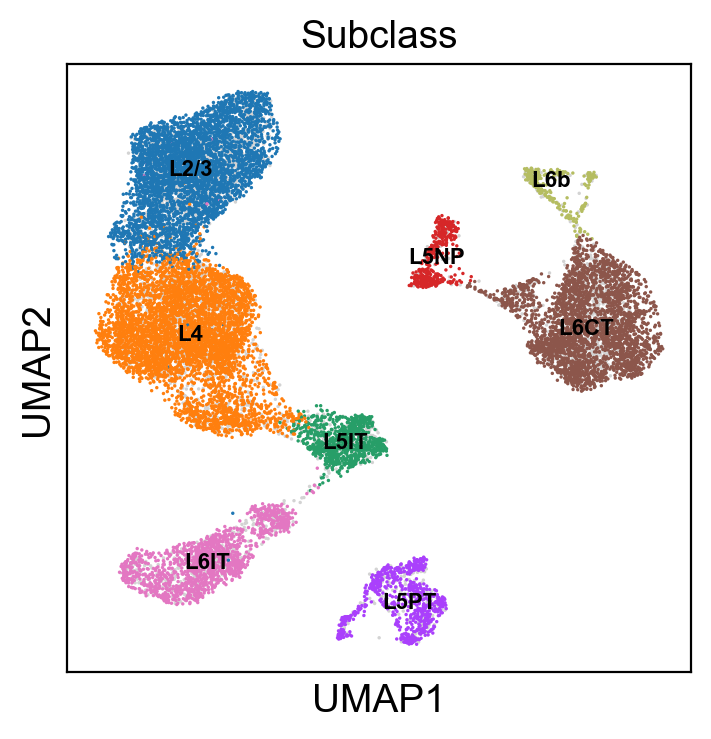

In [13]:
sc.pl.umap(adata, color=["Subclass"], legend_loc="on data", na_in_legend=False, legend_fontsize=8)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


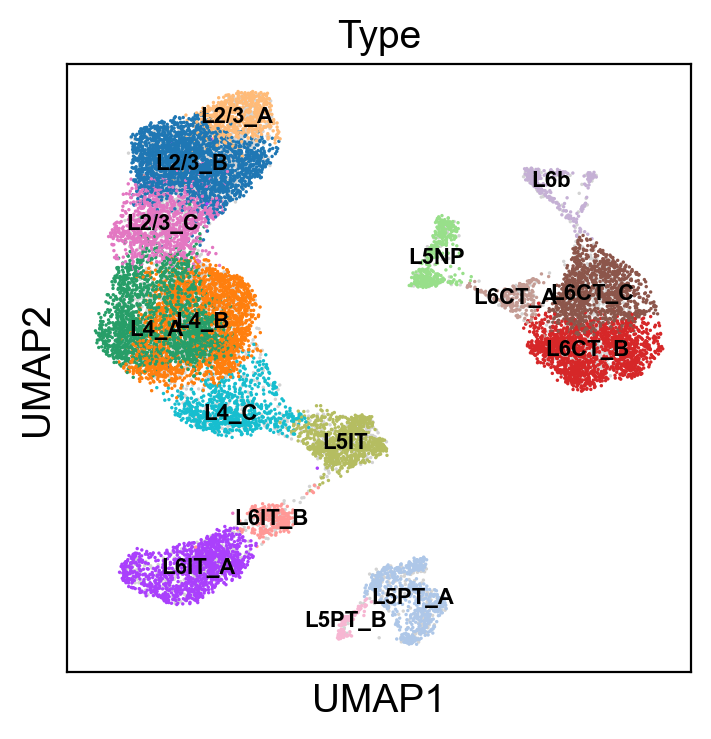

In [14]:
sc.pl.umap(adata, color=["Type"], legend_loc="on data", na_in_legend=False, legend_fontsize=8)

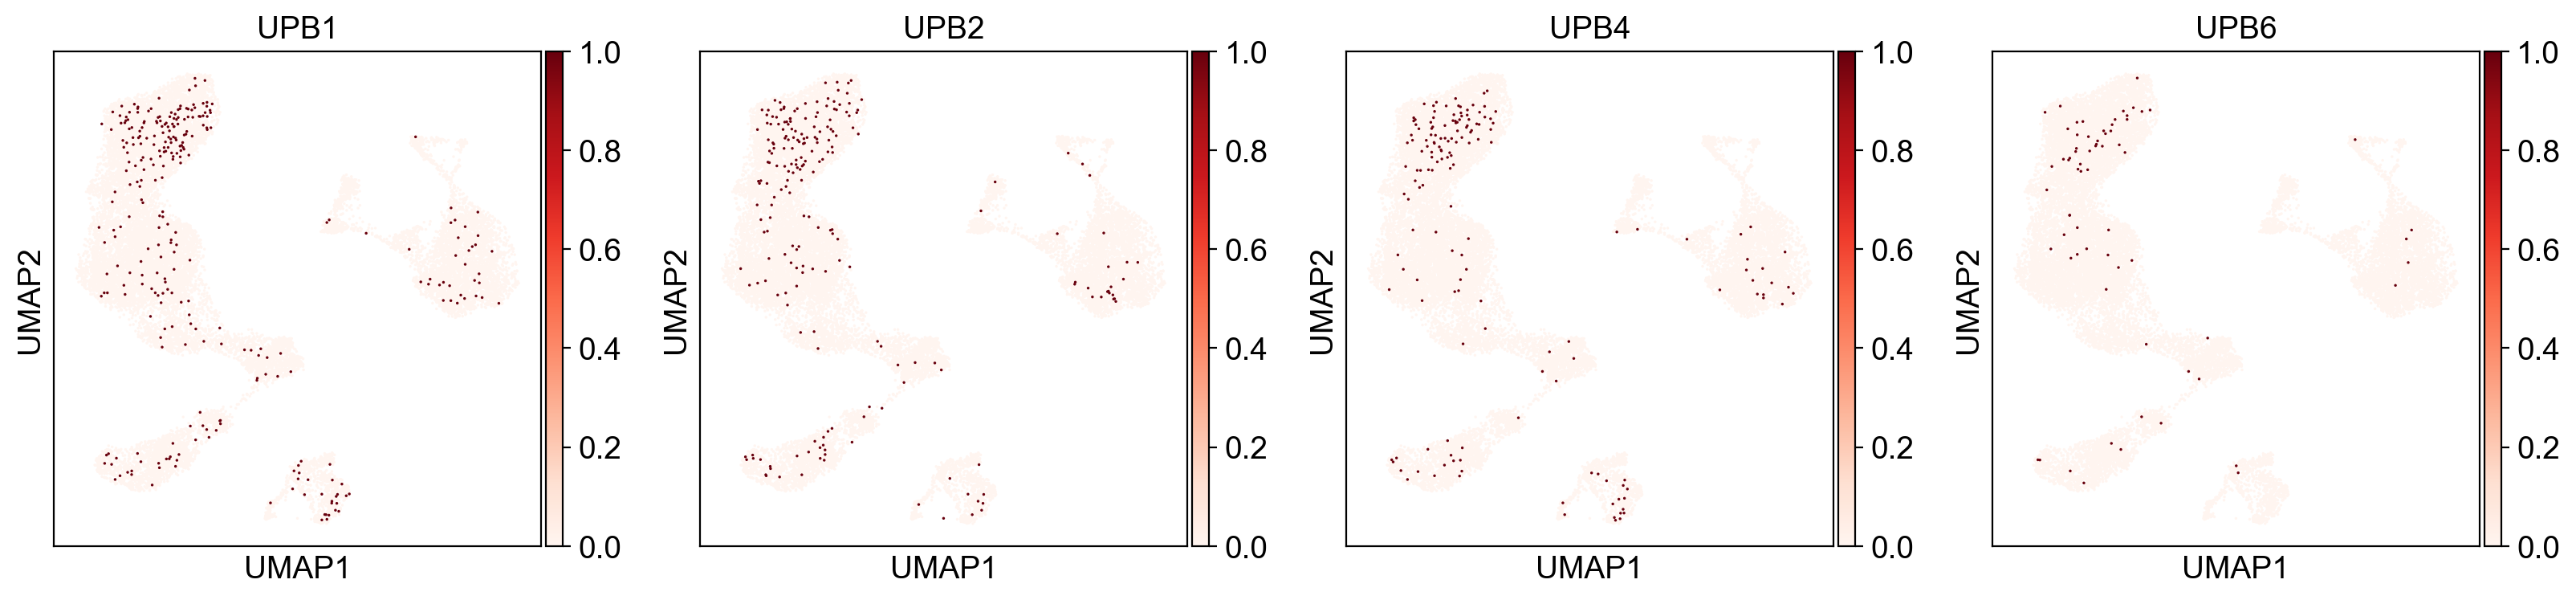

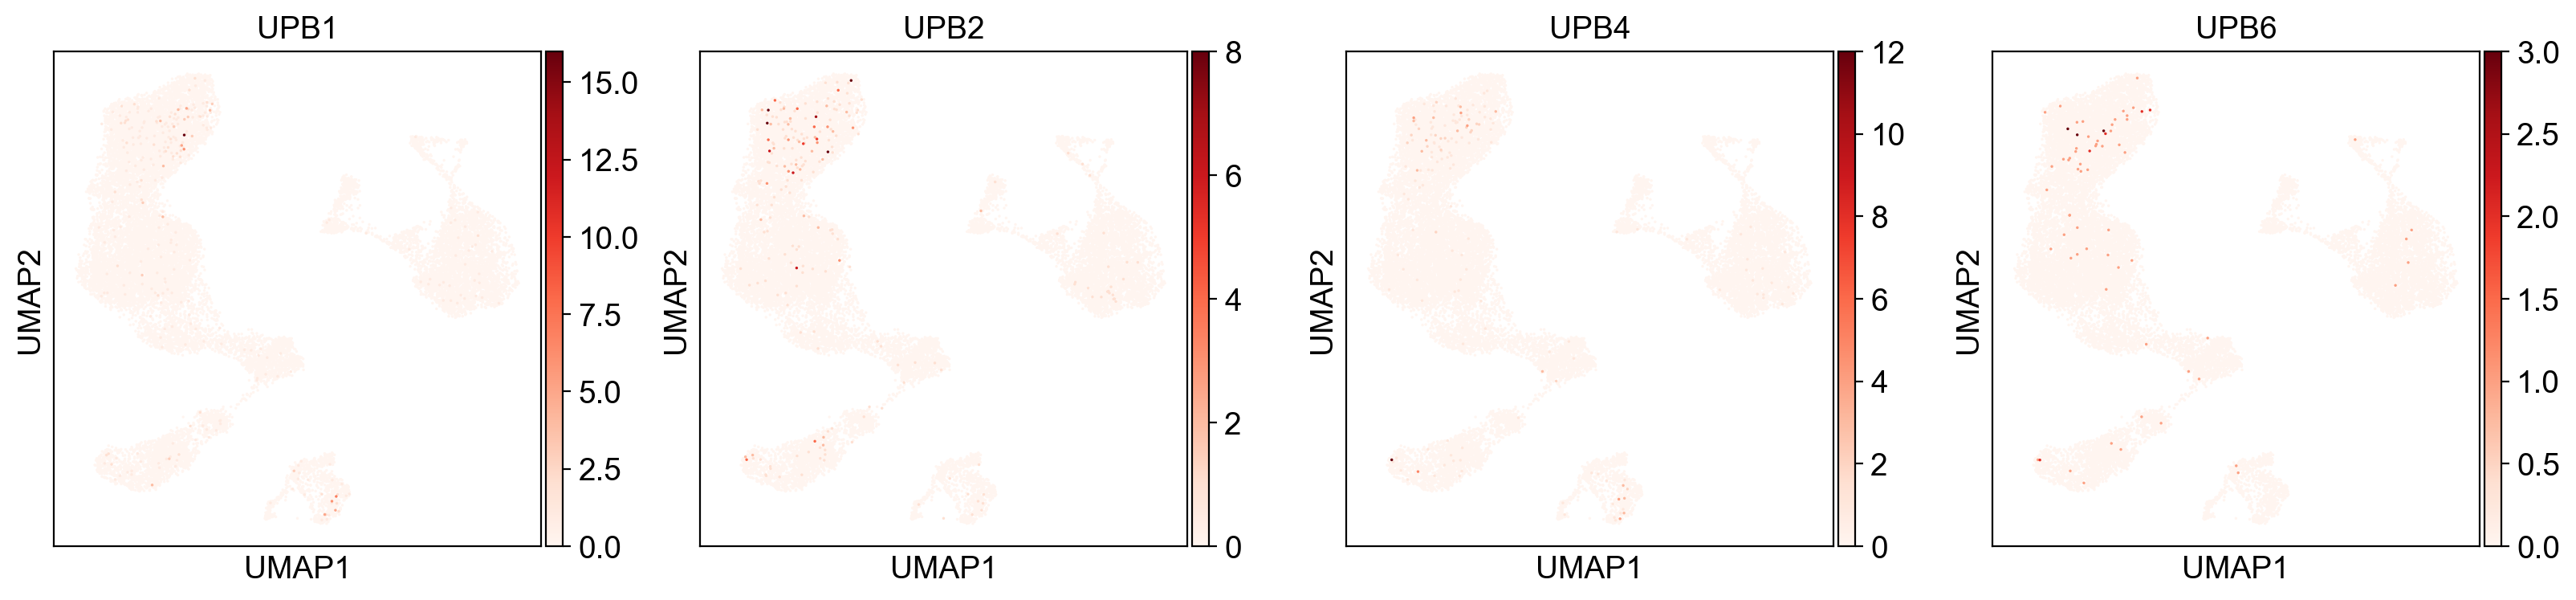

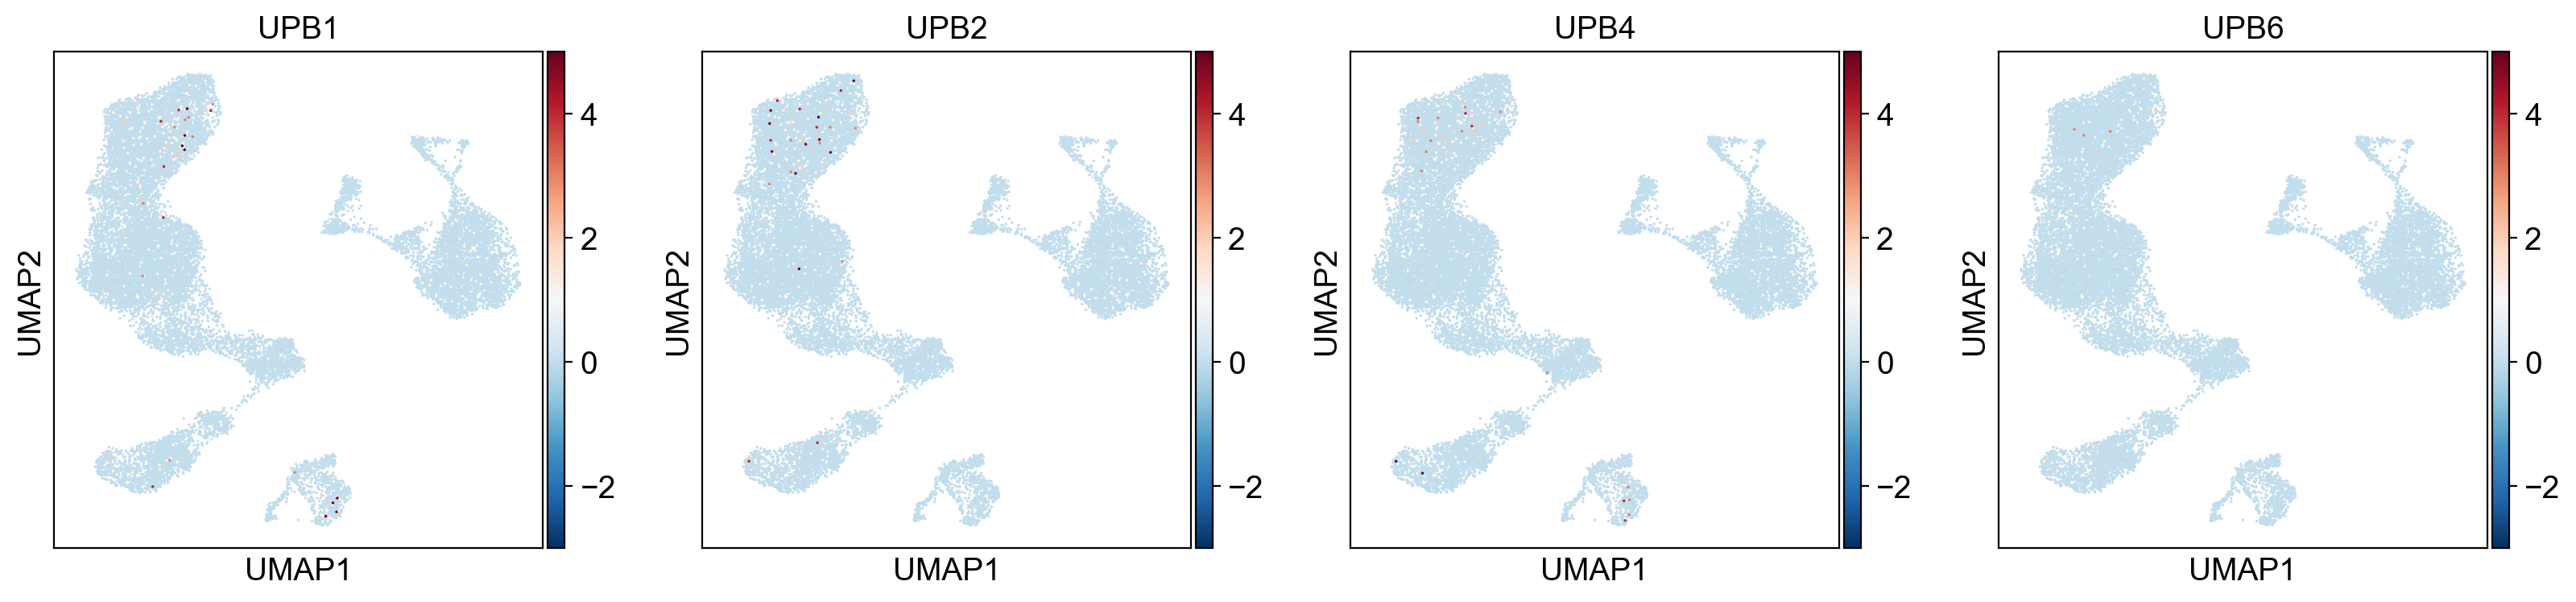

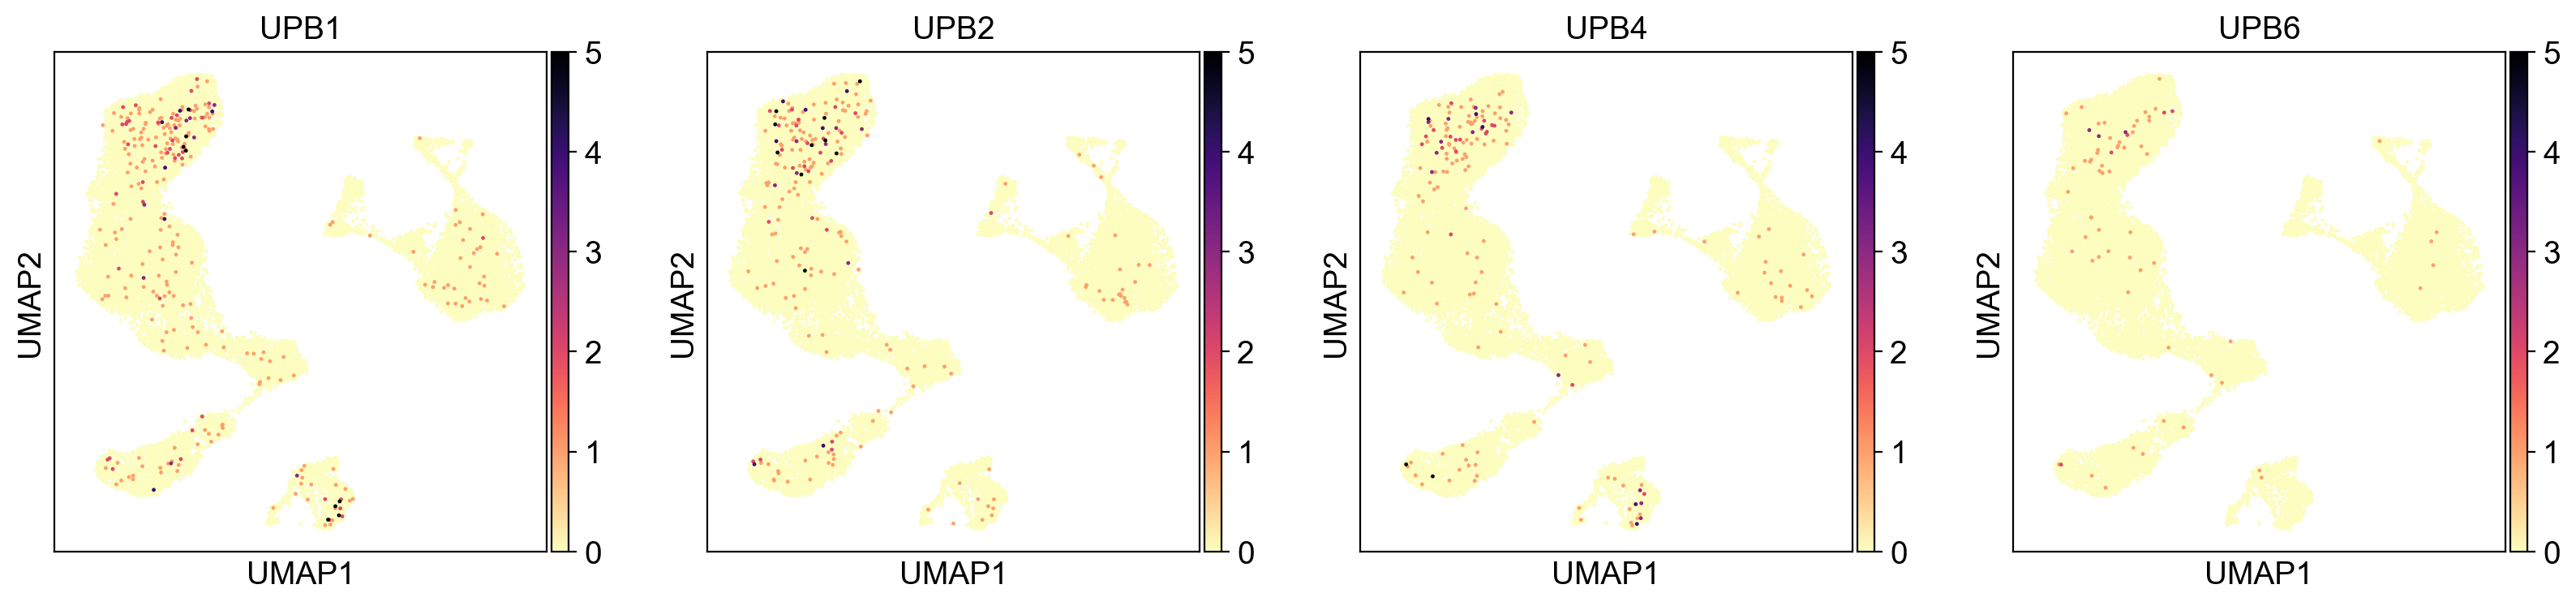

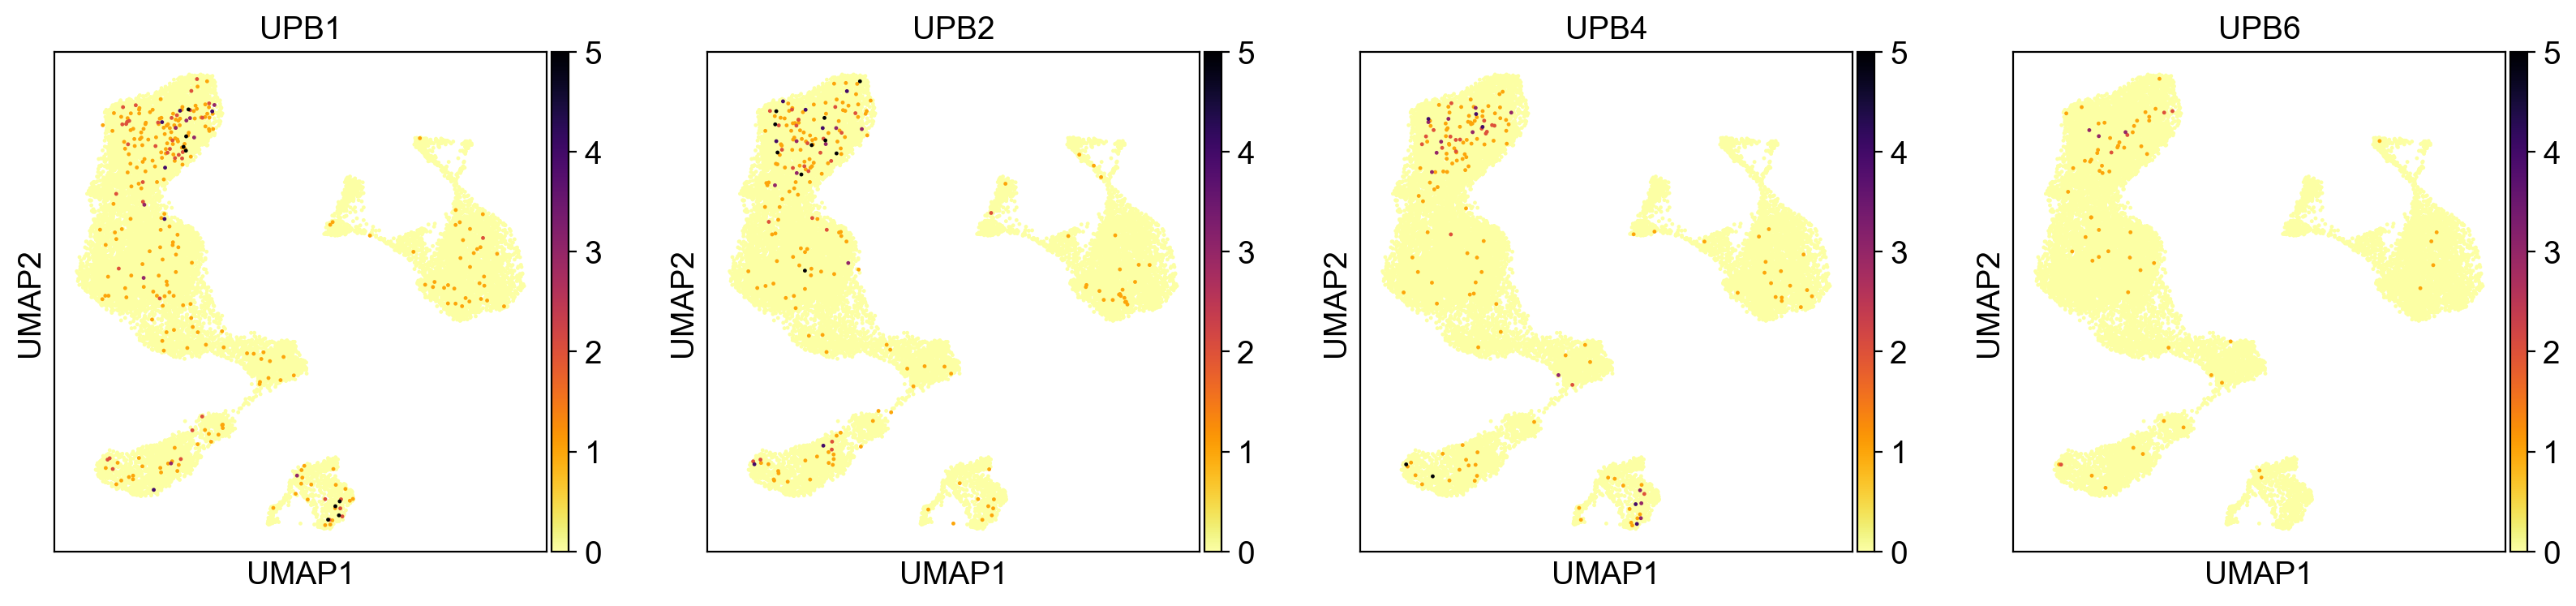

In [30]:
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=1)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds")
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="RdBu_r", vmin=-3, vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="magma_r", vmin=0, vmax=5, size=12)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="inferno_r", vmin=0, vmax=5, size=12)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


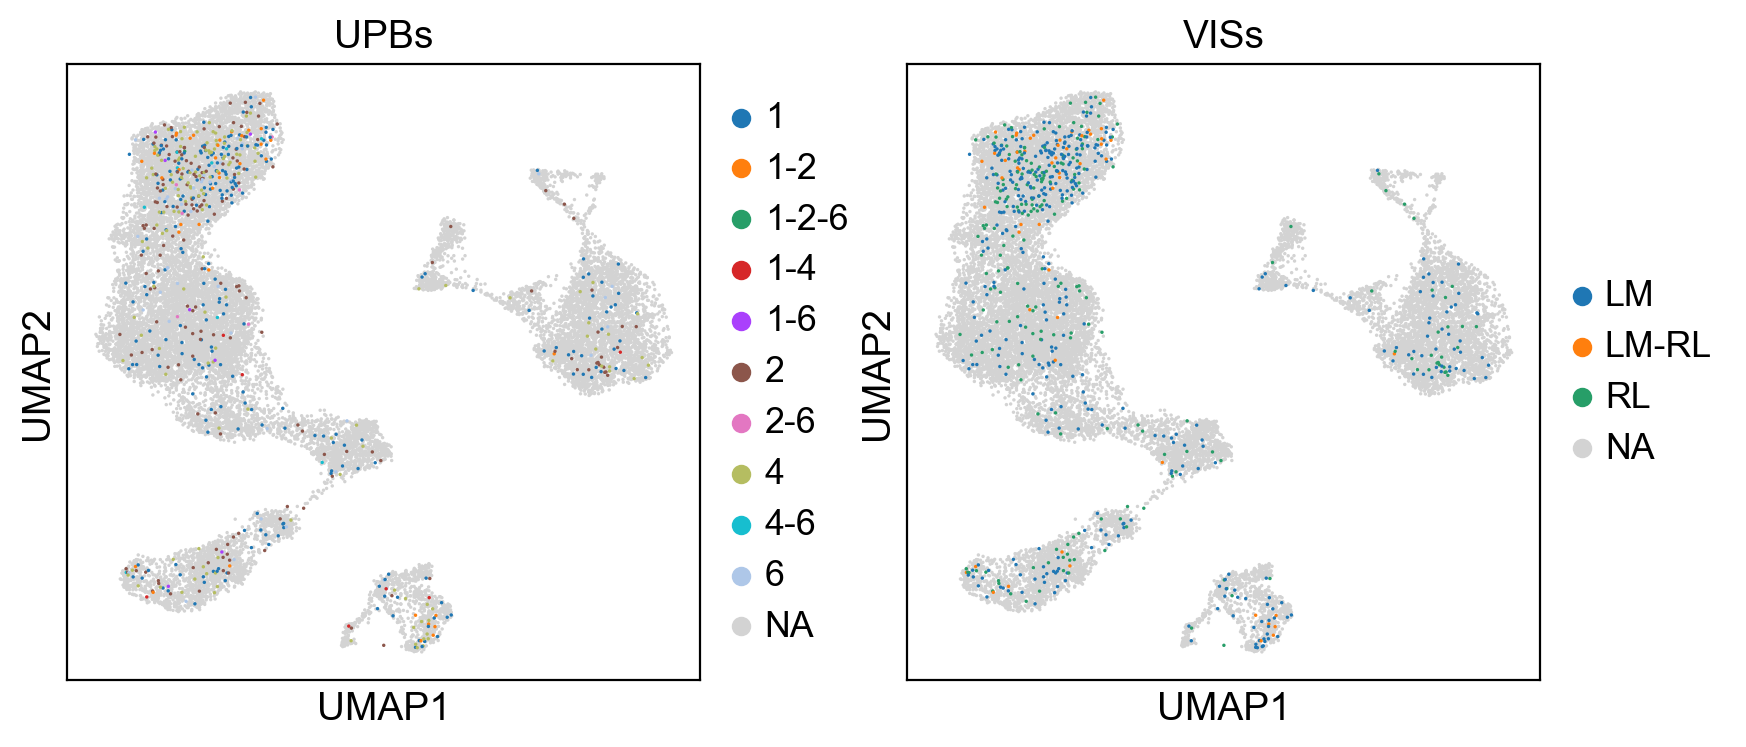

In [16]:
sc.pl.umap(adata, color=["UPBs", "VISs"])

In [17]:
adata.obs["UPBs"] = [None] * adata.shape[0]

upb_combos = ["1", "2", "4", "6", "1-2", "1-4", "1-6", "2-4", "2-6", "4-6", "1-2-4", "1-2-6", "2-4-6"]

for combo in upb_combos:
    cols = ["UPB" + dg for dg in combo.split("-")]
    mask = np.sum(adata.obs[cols] > 1, axis=1) == len(cols)
    adata.obs.loc[mask, "UPBs"] = combo

In [18]:
adata.obs["LM"] = np.sum(adata.obs[["UPB1", "UPB4"]], axis=1) > 1
adata.obs["RL"] = np.sum(adata.obs[["UPB2", "UPB6"]], axis=1) > 1

In [19]:
adata.obs["VISs"] = [None] * adata.shape[0]

vis_combos = ["LM", "RL", "LM-RL"]

for combo in vis_combos:
    cols = combo.split("-")
    mask = np.sum(adata.obs[cols] == True, axis=1) == len(cols)
    adata.obs.loc[mask, "VISs"] = combo

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


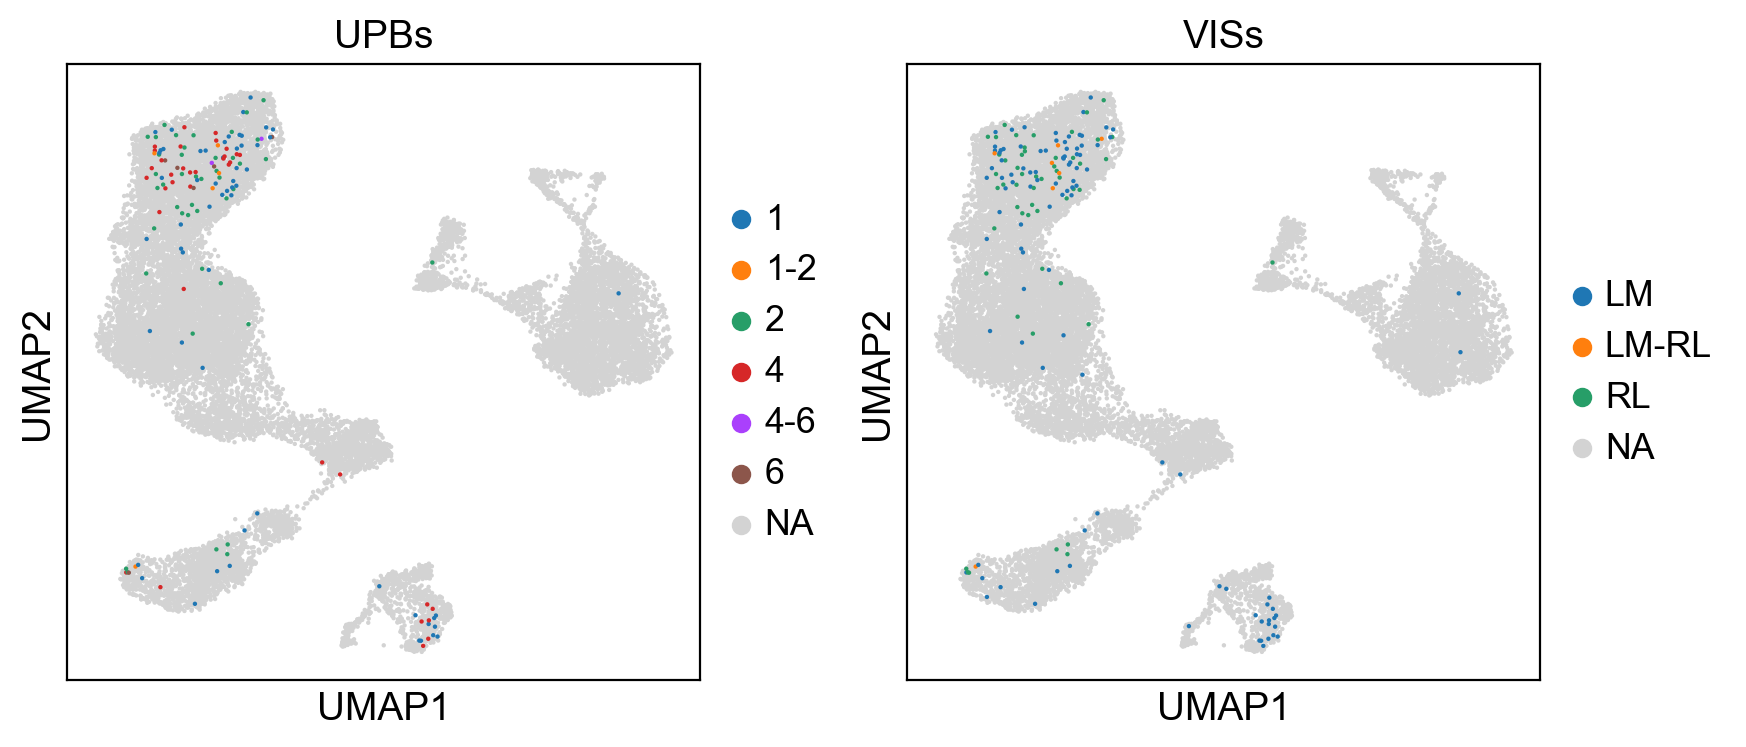

In [21]:
sc.pl.umap(adata, color=["UPBs", "VISs"], size=10)